# Annotation

Consider a binary classification problem. We will fit a predictor and use it to assign a weight score to each node in each instance; this operation is referred to as "annotation". For illustration purposes we will display a few annotated graphs. We will see that building a predictor on the annotated instances can increase the predictive performance.

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


load data and convert it to graphs

In [11]:
pos = 'http://www.bioinf.uni-freiburg.de/~costa/bursi_pos.gspan'
neg = 'http://www.bioinf.uni-freiburg.de/~costa/bursi_neg.gspan'

from eden.converter.graph.gspan import gspan_to_eden
iterable_pos = gspan_to_eden( pos )
iterable_neg = gspan_to_eden( neg )

#split train/test
train_test_split=0.7
from eden.util import random_bipartition_iter
iterable_pos_train, iterable_pos_test = random_bipartition_iter(iterable_pos, relative_size=train_test_split)
iterable_neg_train, iterable_neg_test = random_bipartition_iter(iterable_neg, relative_size=train_test_split)

Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
"GET /~costa/bursi_pos.gspan HTTP/1.1" 200 714032
Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
"GET /~costa/bursi_neg.gspan HTTP/1.1" 200 538391


setup the vectorizer

In [12]:
complexity = 1
n_iter_search = 1

In [13]:
from eden.graph import Vectorizer
vectorizer = Vectorizer( complexity=complexity )

In [14]:
%%time
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)
iterable_neg_train,iterable_neg_train_=tee(iterable_neg_train)
iterable_pos_test,iterable_pos_test_=tee(iterable_pos_test)
iterable_neg_test,iterable_neg_test_=tee(iterable_neg_test)

from eden.util import fit,estimate
estimator = fit(iterable_pos_train_, iterable_neg_train_,
                vectorizer, n_iter_search=n_iter_search)
estimate(iterable_pos_test_, iterable_neg_test_, estimator, vectorizer)

Positive data: Instances: 1680 ; Features: 1048577 with an avg of 63 features per instance
Negative data: Instances: 1355 ; Features: 1048577 with an avg of 60 features per instance
Elapsed time: 9.5 secs
Test set
Instances: 1302 ; Features: 1048577 with an avg of 63 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.75      0.82      0.78       581
          1       0.84      0.78      0.81       721

avg / total       0.80      0.79      0.80      1302

APR: 0.894
ROC: 0.873
Cross-validated estimate
            accuracy: 0.779 +- 0.023
           precision: 0.807 +- 0.020
              recall: 0.789 +- 0.032
                  f1: 0.798 +- 0.022
   average_precision: 0.870 +- 0.022
             roc_auc: 0.849 +- 0.027
CPU times: user 10.2 s, sys: 2.22 s, total: 12.4 s
Wall time: 16.1 s


annotate instances and list all resulting graphs

display one graph as an example. Color the vertices using the annotated 'importance' attribute.

In [15]:
help(vectorizer.annotate)

Help on method annotate in module eden.graph:

annotate(self, graphs, estimator=None, reweight=1.0, relabel=False) method of eden.graph.Vectorizer instance
    Write importance and weight attribute according to estimator.
    
    Given a list of networkx graphs, and a fitted estimator, return a list
    of networkx graphs where each vertex has an additional attribute with
    key 'importance'. The importance value of a vertex corresponds to the
    part of the score that is imputable to the neighborhood of radius r+d
    of the vertex.
    It can overwrite the label attribute with the sparse vector
    corresponding to the vertex induced features.
    
    Parameters
    ----------
    estimator : scikit-learn estimator
        Scikit-learn predictor trained on data sampled from the same
        distribution. If None the vertex weights are set by default 1.
    
    reweight : float (default 1.0)
        The  coefficient used to weight the linear combination of the
        current wei

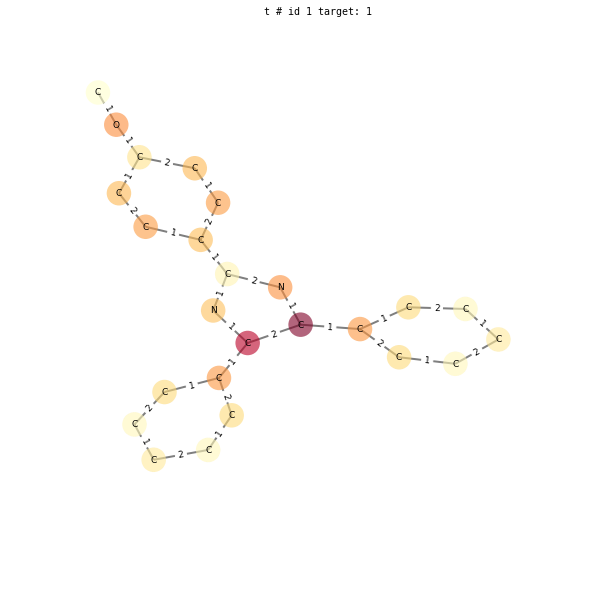

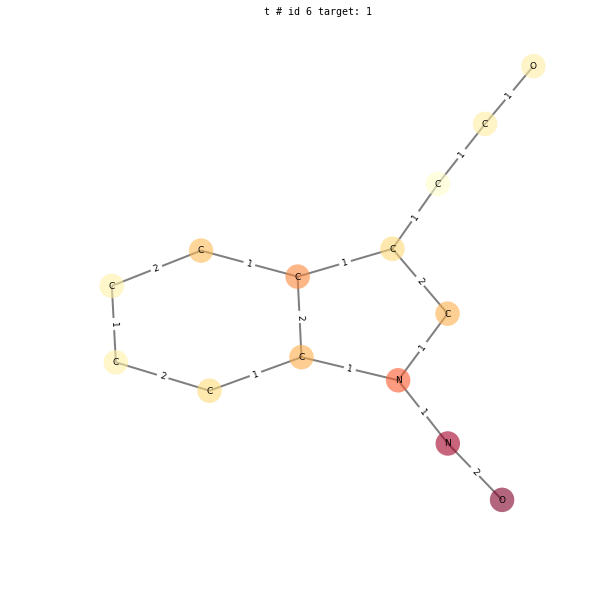

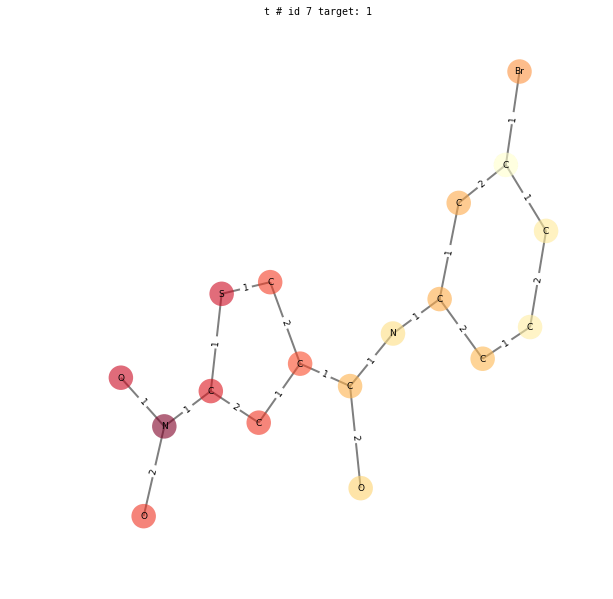

In [16]:
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)

graphs = vectorizer.annotate( iterable_pos_train_, estimator=estimator )

import itertools 
graphs = itertools.islice(graphs,3)

from eden.util.display import draw_graph
for graph in graphs: draw_graph(graph, vertex_color='importance', size=10)

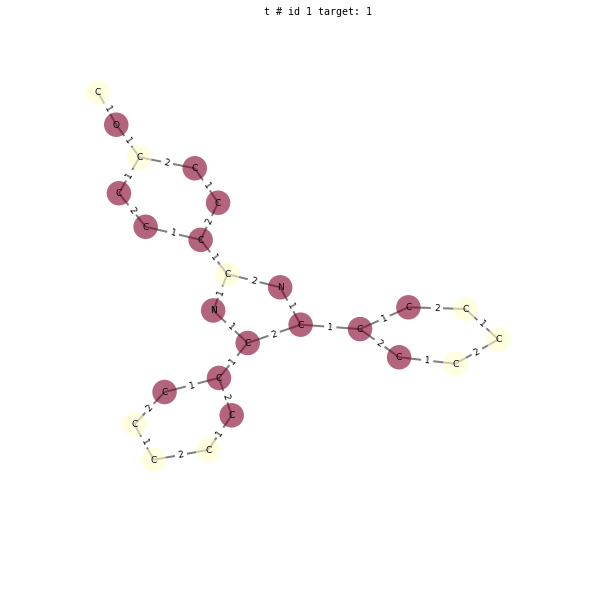

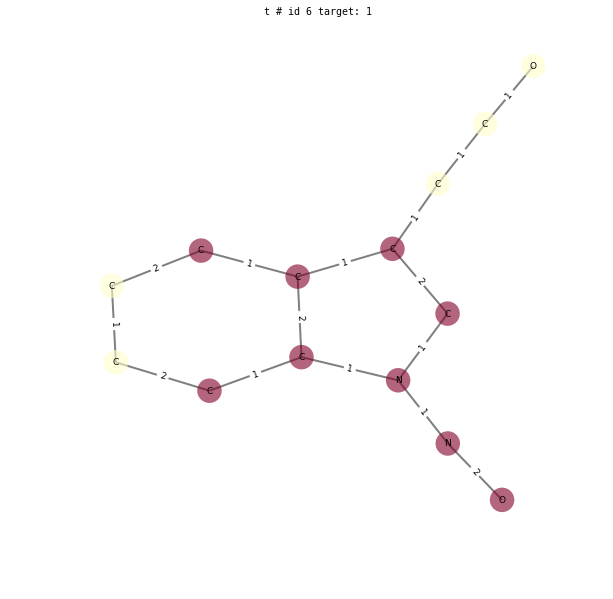

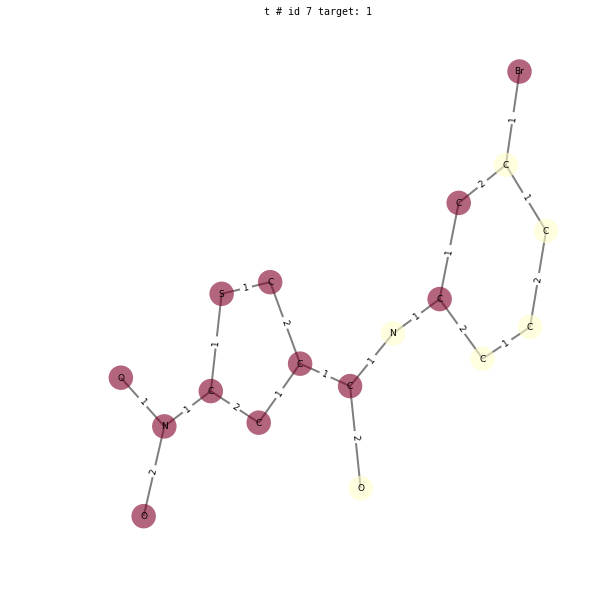

In [17]:
%matplotlib inline
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)

graphs = vectorizer.annotate( iterable_pos_train_, estimator=estimator )

from eden.modifier.graph.vertex_attributes import colorize_binary
graphs = colorize_binary(graph_list = graphs, output_attribute = 'color_value', input_attribute='importance', level=0)

import itertools 
graphs = itertools.islice( graphs, 3 )

from eden.util.display import draw_graph
for graph in graphs: draw_graph( graph, vertex_color='color_value', size=10 )

Create a data matrix this time using the annotated graphs. Note that now graphs are weighted. 

Evaluate the predictive performance on the weighted graphs.

In [ ]:
%%time
a_estimator=estimator
num_iterations = 30
reweight = 0.5
for i in range(num_iterations):
    print 'Iteration %d/%d'%(i+1,num_iterations)
    
    from itertools import tee
    iterable_pos_train_=vectorizer.annotate( iterable_pos_train, estimator=a_estimator, reweight=reweight )
    iterable_neg_train_=vectorizer.annotate( iterable_neg_train, estimator=a_estimator, reweight=reweight )
    iterable_pos_test_=vectorizer.annotate( iterable_pos_test, estimator=a_estimator, reweight=reweight )
    iterable_neg_test_=vectorizer.annotate( iterable_neg_test, estimator=a_estimator, reweight=reweight )
    
    iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train_)
    iterable_neg_train,iterable_neg_train_=tee(iterable_neg_train_)
    iterable_pos_test,iterable_pos_test_=tee(iterable_pos_test_)
    iterable_neg_test,iterable_neg_test_=tee(iterable_neg_test_)

    from eden.util import fit,estimate
    a_estimator = fit(iterable_pos_train_, iterable_neg_train_, 
                      vectorizer, n_iter_search=n_iter_search)
    estimate(iterable_pos_test_, iterable_neg_test_, a_estimator, vectorizer)

---